### How big is my DataFrame?
`df.info()` , `df.memory_usage()`

### NumPy transformations
- Many NumPy transformations, while fast, use one or more temporary arrays. Therefore, those transformations require more storage than the original array required.
- The function memory_footprint() has been provided to return the total amount of memory (in megabytes or MB) currently in use by our program. This function uses the psutil and os modules.

In [16]:
import numpy as np
import psutil, os
import matplotlib.pyplot as plt
# from glob import glob
import glob
import pandas as pd

def memory_footprint():
    '''Returns memory (in MB) being used by Python process'''
    mem = psutil.Process(os.getpid()).memory_info().rss
    return (mem / 1024 **2)

In [17]:
N = (1024 **2) //8 # number of floats that fill 1 MB
celsius = np.random.randn(50 * N) # Random array filling 50MB

# Print the size in MB of the celsius array
print(celsius.nbytes / 1024**2)

# Call memory_footprint(): before
before = memory_footprint()

# Convert celsius by multiplying by 9/5 and adding 32: fahrenheit
fahrenheit = celsius * 9/5 + 32

# Call memory_footprint(): after
after = memory_footprint()

# Print the difference between after and before
print(after - before)

50.0
0.0


### Computing percentage of delayed flights
- build a function to compute the percentage of delayed flights given a DataFrame of flight information. 


In [18]:
# Define function with single input called df: pct_delayed
def pct_delayed(df):
    # Compute number of delayed flights: n_delayed
    n_delayed = (df['DEP_DELAY'] > 0).sum()
    # Return percentage of delayed flights
    return n_delayed  * 100 / len(df)


### Generating & plotting delayed flights

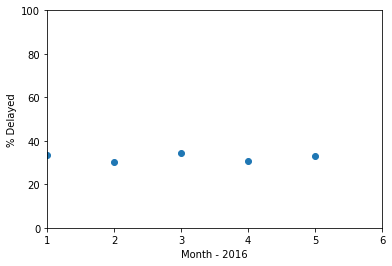

In [19]:
# Define the generator: dataframes
filenames = glob.glob('../data/flightdelays/*.csv')
dataframes = (pd.read_csv(file) for file in filenames)

# Create the list comprehension: monthly_delayed
monthly_delayed = [pct_delayed(df) for df in dataframes]

# Create the plot
x = range(1,6)
plt.plot(x, monthly_delayed, marker='o', linewidth=0)
plt.ylabel('% Delayed')
plt.xlabel('Month - 2016')
plt.xlim((1,6))
plt.ylim((0,100))
plt.show()

### Building a pipeline with delayed
- If we use `dask.delayed`, we don't need to use generators; the dask scheduler will manage memory usage.
- **Task** : define three decorated functions to complete the pipeline: a function to total the number of flights, a function to count the number of delayed flights, and a function to aggregate the results.

In [20]:
from dask import delayed
import os 
import glob
import pandas as pd

C:\Users\Shubham\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [21]:
# Define count_flights
@delayed
def count_flights(df):
    return len(df)

# Define count_delayed
@delayed
def count_delayed(df):
    return (df['DEP_DELAY']>0).sum()

# Define pct_delayed
@delayed
def pct_delayed(n_delayed, n_flights):
    return 100 * sum(n_delayed) / sum(n_flights)

- These functions constitute the pieces of the pipeline for our flight-delay analysis

### Computing pipelined results
- Now that the dask.delayed functions are defined, we can use them to construct the pipeline of delayed tasks.
-  loop over the file names, store the temporary information in lists, and aggregate the final result.
- The distinction here is that we are working with `dask.delayed` functions and objects, not real, computed values. The computation will only be executed when we call `.compute()` on the final result.

In [22]:
filenames = glob.glob('../data/flightdelays/*.csv')
filenames

['../data/flightdelays\\flightdelays-2016-1.csv',
 '../data/flightdelays\\flightdelays-2016-2.csv',
 '../data/flightdelays\\flightdelays-2016-3.csv',
 '../data/flightdelays\\flightdelays-2016-4.csv',
 '../data/flightdelays\\flightdelays-2016-5.csv']

In [23]:
n_delayed = []
n_flights = []
# Loop over the provided filenames list and call read_one: df
for file in filenames:
    df = pd.read_csv(file)

    # Append to n_delayed and n_flights
    n_delayed.append(count_delayed(df))
    n_flights.append(count_flights(df))

# Call pct_delayed with n_delayed and n_flights: result
result = pct_delayed(n_delayed, n_flights)

# Print the output of result.compute()
print(result.compute())

32.406252934201824


- Notice that no reading and no computation was done until the last line (result.compute()). In all the preceding lines, the functions called returned dask.delayed objects that deferred execution until the invocation of compute().

### Subtracting & broadcasting
- The one-dimensional array load_2001 holds the total electricity load for the state of Texas sampled every 15 minutes for the entire year 2001 (35040 samples in total). The one-dimensional array load_recent holds the corresponding data sampled for each of the years 2013 through 2015 (i.e., 105120 samples consisting of the samples from 2013, 2014, & 2015 in sequence). None of these years are leap years, so each year has 365 days. Observe also that there are 96 intervals of duration 15 minutes in each day.
- compute the differences of the samples in the years 2013 to 2015 each from the corresponding samples of 2001.

In [45]:
import numpy as np
import h5py

hf = h5py.File('../data/Texas/texas.2001.hdf5', 'r')
print('dataset name:', hf.keys())
load_2001 = np.array(hf["load"][:]) #dataset_name is same as hdf5 object name 
load_2001.shape

dataset name: <KeysViewHDF5 ['load']>


(35040,)

In [43]:
hf = h5py.File('../data/Texas/texas.2013.hdf5', 'r')
hf_14 = h5py.File('../data/Texas/texas.2014.hdf5', 'r')
hf_15 = h5py.File('../data/Texas/texas.2015.hdf5', 'r')
print('dataset name:', hf.keys())
load_2013 = np.array(hf["load"][:]) #dataset_name is same as hdf5 object name 
load_2014 = np.array(hf_14["load"][:])
load_2015 = np.array(hf_15["load"][:])
load_recent = np.hstack([load_2013,load_2014,load_2015])
load_recent.shape

dataset name: <KeysViewHDF5 ['load']>


(105120,)

In [46]:
# Reshape load_recent to three dimensions: load_recent_3d
load_recent_3d = load_recent.reshape((3,365,96))

# Reshape load_2001 to three dimensions: load_2001_3d
load_2001_3d = load_2001.reshape((1,365,96))

# Subtract the load in 2001 from the load in 2013 - 2015: diff_3d
diff_3d = load_recent_3d - load_2001_3d

# Print the difference each year on March 2 at noon
print(diff_3d[:, 61, 48])

[-1153.309    22.598   -17.925]


### Computing aggregations
- compute summary statistics by aggregating NumPy arrays across various dimensions (in this case, giving trends in electricity usage).
- `load_recent_3d` contains the electricity load (in kWh) sampled every 15 minutes from the start of 2013 to the end of 2015. The possible index values of the three-dimensional array correspond to year (from 0 to 2), day (from 0 to 364), and 15-minute interval (from 0 to 95); remember, NumPy arrays are indexed from zero. Thus, load_recent_3d[0,1,2] is the electricity load consumed on January 2nd, 2013 from 00:30:00 AM to 00:45:00 AM.


In [47]:
# Print mean value of load_recent_3d
print(load_recent_3d.mean())

# Print maximum of load_recent_3d across 2nd & 3rd dimensions
print(load_recent_3d.max(axis=(1,2)))

# Compute sum along last dimension of load_recent_3d: daily_consumption
daily_consumption = load_recent_3d.sum(axis=-1)

# Print mean of 62nd row of daily_consumption
print(daily_consumption[:,61].mean())

5240.84666194825
[6335.42  6336.159 6344.077]
470184.43899999995


### Inspecting a large DataFrame

### Building a pipeline of delayed tasks
- filter the DataFrame for the 'East Asia & Pacific' region and measurements of the percent population exposed to toxic air pollution. The output of this effort is a delayed Dask DataFrame

In [1]:
# Read from 'WDI.csv': df
import dask.dataframe as dd

df = dd.read_csv('../data/WDI/WDI.csv')

# Boolean series where 'Indicator Code' is 'EN.ATM.PM25.MC.ZS': toxins
toxins = df['Indicator Code'] == 'EN.ATM.PM25.MC.ZS'
# Boolean series where 'Region' is 'East Asia & Pacific': region
region = df['Region'] == 'East Asia & Pacific'

# Filter the DataFrame using toxins & region: filtered
filtered = df.loc[toxins & region]

C:\Users\Shubham\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Shubham\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


AttributeError: module 'pandas.compat' has no attribute 'string_types'

### Grouping & aggregating by year
-  plot the average percent of the population exposed to air pollution in the East Asia & Pacific region from 2010 to 2015.
- use .groupby() to collect all of the individual country values by the 'Year' column and aggregate with the mean() function. Then call .compute() to perform the computation in parallel, and finally plot the results.